# Results

In [12]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [13]:
results = pd.read_csv('./logs/2023_07_19/0/results.txt')

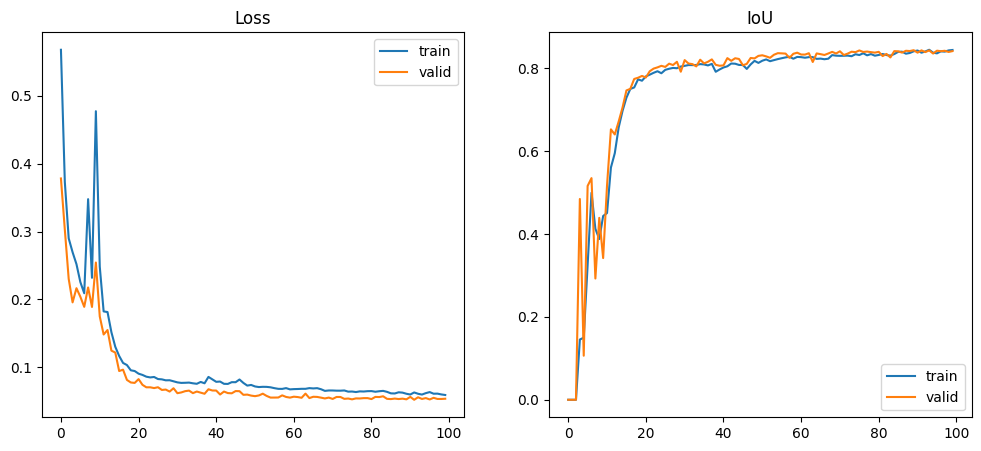

In [14]:
train_results = results.query("phase=='train'").reset_index(drop=True)
valid_results = results.query("phase=='valid'").reset_index(drop=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(train_results['loss'], label='train')
axes[0].plot(valid_results['loss'], label='valid')
axes[0].set_title('Loss')
axes[0].legend()
axes[1].plot(train_results['IoU'], label='train')
axes[1].plot(valid_results['IoU'], label='valid')
axes[1].set_title('IoU')
axes[1].legend()
plt.show()


---

# Inference

In [15]:
import cv2
from pathlib import Path

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from model import Unet
from utils import rle_encode, rle_decode
from params import TEST_PATH

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
test_path = Path(TEST_PATH)
test_img_paths = list(test_path.glob('*/images/*.png'))

model = Unet(3, nb_classes=1).to(device)
model.load_state_dict(torch.load('./logs/2023_07_19/0/model.pth',
                                 map_location=device))

<All keys matched successfully>

In [17]:
results = {'ImageId': [], 'EncodedPixels': [], 'Height': [], 'Width': []}

model.eval()
with torch.inference_mode():
    for i, img_path in enumerate(tqdm(test_img_paths)):
        id_ = img_path.stem
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        height, width = img.shape[:2]

        img_resized = cv2.resize(img, (128, 128))
        img_resized = np.moveaxis(img_resized, -1, 0)
        img_resized = torch.tensor(img_resized[np.newaxis, ...], dtype=torch.float)/255
        img_resized = img_resized.to(device)
        out = model(img_resized)
        out = out.cpu().numpy().squeeze()
        out_resized = cv2.resize(out, (width, height), interpolation=cv2.INTER_CUBIC)
        out_resized = out_resized > 0.5

        results['ImageId'].append(id_)
        results['EncodedPixels'].append(rle_encode(out_resized))
        results['Height'].append(height)
        results['Width'].append(width)

results_df = pd.DataFrame(results).sort_values('ImageId').reset_index(drop=True)

100%|██████████| 65/65 [00:00<00:00, 95.48it/s] 


In [18]:
gt_df = pd.read_csv('./data/stage1_solution_merged.csv')

decoded_pred = []
decoded_gt = []

iou = []
for (_, pred), (_, true) in zip(results_df.iterrows(), gt_df.iterrows()):
    pred_d = rle_decode(pred['EncodedPixels'], (pred['Height'], pred['Width']))
    true_d = rle_decode(true['EncodedPixels'], (true['Height'], true['Width']))
    
    intersection = pred_d * true_d
    union = (pred_d + true_d).clip(0, 1)
    iou.append(intersection.sum() / union.sum())

print(f"Average IoU on Stage 1 Test set: {np.mean(iou):.4f}")

Average IoU on Stage 1 Test set: 0.6463


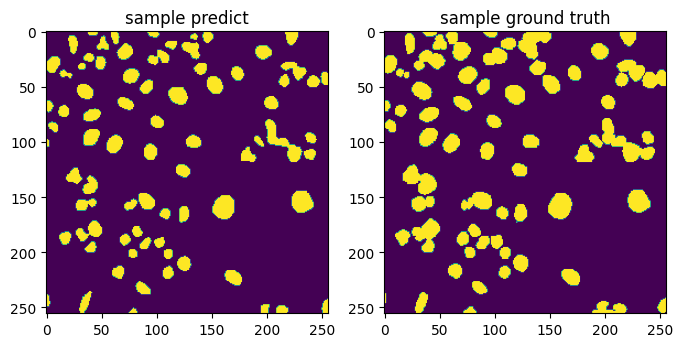

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(8, 5))
axes[0].imshow(pred_d)
axes[0].set_title('sample predict')
axes[1].imshow(true_d)
axes[1].set_title('sample ground truth')
plt.show()